In [61]:
import os
import requests

#Get PDF download path
pdf_path = "student_information_handbook.pdf"

#Download PDF if not available
if not os.path.exists(pdf_path):
    print(f"[INFO] file doesn't exist, downloading...")
    #Enter url of PDF
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    #the local filename to save the downloaded file
    file_name = pdf_path

    #Send a GET request to the URL
    response = requests.get(url)

    #Check if the request was successful
    if response.status_code == 200:#okay status
        #Open the file and save it
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {file_name}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists")
    


File student_information_handbook.pdf exists


In [62]:
import fitz #requires PyMuPDF
from tqdm.auto import tqdm #for progress bars

#Breaking down big tasks into helper function is a good practise!

def text_formatter(text: str) -> str:
    '''Performs minor formatting on text.'''
    cleaned_text = text.replace("\n"," ").strip()

    #Potentially more text formatting functions can go here (based on specifics of your document data)
    return cleaned_text

#Better formatted text will provide better context to LLM and hence, better responses

def open_and_read_pdf(pdf_path: str) -> list[dict]:#list[dict] is very easy to convert into dataframes, that's why we are planning to store pdf in that format
    doc = fitz.open(pdf_path)

    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number+1, 
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),#raw bcoz it uses a very naive heuristic for detecting sentences
                                "page_token_count": len(text)/4, # 1 token ~ 4 characters Sauce: Key terms in Github Repo + https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

#OpenAI's tokenizer tool: https://platform.openai.com/tokenizer
#Must do Karpathy's "Let's Build GPT Tokenizer" to be THOROUGH!

0it [00:00, ?it/s]

89it [00:00, 247.98it/s]


[{'page_number': 1,
  'page_char_count': 45,
  'page_word_count': 7,
  'page_sentence_count_raw': 1,
  'page_token_count': 11.25,
  'text': 'STUDENT INFORMATION HANDBOOK 2024  Version II'},
 {'page_number': 2,
  'page_char_count': 1003,
  'page_word_count': 203,
  'page_sentence_count_raw': 16,
  'page_token_count': 250.75,
  'text': 'Page 2 of 89  INDEX  Chapter   Title  Page No.  1.  Course Programmes [MTech, MTech (Online),  MDes, MMgt, MSc, MEngg, 1+1 Joint Masters]  5  2.  PG – Research Programmes – MTech (Res)  12  3.  PhD Programmes – Science, Engineering, and  Interdisciplinary Research  17  4.  Integrated PhD Programmes  25  5.  External Registration Programmes – PhD and  MTech (Res), Quality Improvement Programme  (QIP) and Sponsored Programme  31  6.  Course Registration, Mapping of Research  Supervisor, Grading System and Continuous  Assessment  34  7.  Fee Structure  38  8.  Scholarships and Fellowships  43  9.  Attendance and Leave Rules  47  10.  Discontinuation of Studi

If you want to access page number k, do pages_and_texts[k-1]

In [63]:
pages_and_texts[5]

{'page_number': 6,
 'page_char_count': 2503,
 'page_word_count': 497,
 'page_sentence_count_raw': 19,
 'page_token_count': 625.75,
 'text': 'Page 6 of 89    1.1.5  The stipulation on the minimum number of credits does not apply to the final term.  On all matters connected with course work and the prescribed requirements for the degree,  students should seek the guidance of their advisors, DCC Convenor and/or the Chair of the  department.  1.1.6  For all course programmes, the credit load per term (including project credits) is as  follows:  Credit Load  No. of Credits    Regular Term  Summer Term  Normal  16  8  Minimum  12  6  Maximum (in 1st Term)  18  –  Maximum (if TGPA/ CGPA in the  previous Term is < 7.0 But ≥ 5.0)    16    8  Maximum if TGPA/CGPA is ≥ 7.0  but < 9.0  18  8  Maximum if TGPA/CGPA is ≥ 9.0  21  8  Table 1.2 – Allowed Credit Load    1.1.7  Students may be allowed to complete the programme at a slower pace. This requires  prior approval of the Deans, based on a recom

In [64]:
import random 

random.sample(pages_and_texts, k=3)

[{'page_number': 79,
  'page_char_count': 2458,
  'page_word_count': 402,
  'page_sentence_count_raw': 13,
  'page_token_count': 614.5,
  'text': 'Page 79 of 89    \uf0a7 Health: Coordination between health centre and students  \uf0a7 Women’s Welfare: Work with Women Cell for the welfare of the women students  \uf0a7 Cultural: Organizing and promoting intra and inter-institute cultural events  \uf0a7 Environment: Reducing the institute’s environmental footprint, expanding the green  cover  There are also other committees like social, UG Welfare, Foreign Student Welfare.  Email: office.sc@iisc.ac.in  Contact No: 080 2293 2653    Note: The student council’s reconstitution is now under process.      15.6 Students’ body for Innovation and Entrepreneurship (EntIISc)  EntIISc is the abbreviation for ‘Entrepreneurship and Innovation at IISc’. It is a student-run  forum to encourage, promote and support entrepreneurship and innovation activities at IISc.  It aims to become a welcoming forum to

Observations: 
Why is it mentioning the footer containing page numbers at the top?<br>
It reads tabular data well, but it is reading it in row wise manner and not stating any relation between them, there can be a better way to represent them coherently, first step towards this - would be to have the ability to detect that this is indeed a tabular data - the only, we can proceed to do something better way to coherently represent this data.

In [65]:
import pandas as pd 

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,1,45,7,1,11.25,STUDENT INFORMATION HANDBOOK 2024 Version II
1,2,1003,203,16,250.75,Page 2 of 89 INDEX Chapter Title Page No....
2,3,823,166,4,205.75,Page 3 of 89 Chapter Title Page No. The ...
3,4,53,13,2,13.25,Page 4 of 89 17. Auxiliary rules and procedu...
4,5,2080,412,24,520.00,Page 5 of 89 CHAPTER 1 Course Progra...


In [66]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,89.00,89.00,89.00,89.00,89.00
mean,45.00,2101.64,378.06,16.93,525.41
std,25.84,723.35,122.51,7.82,180.84
min,1.00,45.00,7.00,1.00,11.25
25%,23.00,1680.00,326.00,11.00,420.00
50%,45.00,2304.00,409.00,17.00,576.00
75%,67.00,2641.00,459.00,22.00,660.25
max,89.00,3250.00,592.00,40.00,812.50


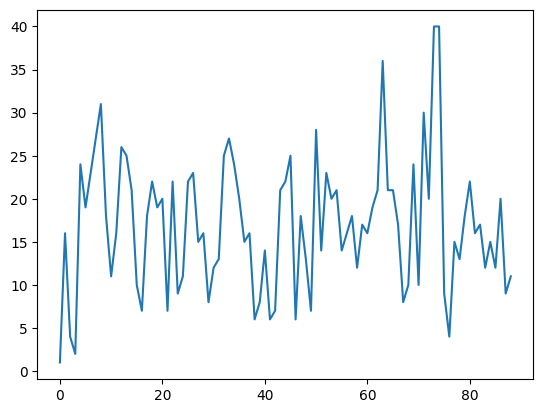

In [67]:
import matplotlib.pyplot as plt
plt.plot(range(0, 89), df["page_sentence_count_raw"])

In [32]:
from spacy.lang.en import English

nlp = English()

#Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
#NEVER UNDERESTIMATE READING THE DOCS - especially when even GPT doesn't make sense

nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    #Make sure all the sentences are strings (the default type is a spaCy datatype) - can be even seen in the output of above cell
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    #Count the sentences
    item["page_sentence_count_spacy"] = len(item['sentences'])

random.sample(pages_and_texts, k = 2)

  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 89/89 [00:00<00:00, 209.43it/s]


[{'page_number': 51,
  'page_char_count': 2748,
  'page_word_count': 475,
  'page_sentence_count_raw': 28,
  'page_token_count': 687.0,
  'text': 'Page 51 of 89  CHAPTER 11  Students’ Assistance Programme  11.1 The details of Teaching Assistance.  TA appointment procedure:  i  All PhD students who have completed their mandatory TA-ship, and Int. PhD students  in their fourth year or beyond may be appointed as TAs. M. Tech (Res) students in their  second year or beyond may be appointed as TAs to provide technical assistance only.  All these categories of students will be paid by IISc grants for their assistance. TAs may  be asked to begin their work on the first working day of the term.  ii  First year Research/M. Tech students cannot be appointed as TA.  iii Students may be appointed as TAs within 30 days of the beginning of the term.  iv Only the TAs who have completed their mandatory TAship will be paid at the rate of Rs  200/hour.  v  TA can be in the form of programmeming assistanc

In [33]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,89.00,89.00,89.00,89.00,89.00
mean,45.00,2101.64,378.06,16.93,525.41
std,25.84,723.35,122.51,7.82,180.84
min,1.00,45.00,7.00,1.00,11.25
25%,23.00,1680.00,326.00,11.00,420.00
50%,45.00,2304.00,409.00,17.00,576.00
75%,67.00,2641.00,459.00,22.00,660.25
max,89.00,3250.00,592.00,40.00,812.50


In [34]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,89.00,89.00,89.00,89.00,89.00,89.00
mean,45.00,2101.64,378.06,16.93,525.41,14.46
std,25.84,723.35,122.51,7.82,180.84,6.65
min,1.00,45.00,7.00,1.00,11.25,1.00
25%,23.00,1680.00,326.00,11.00,420.00,10.00
50%,45.00,2304.00,409.00,17.00,576.00,15.00
75%,67.00,2641.00,459.00,22.00,660.25,19.00
max,89.00,3250.00,592.00,40.00,812.50,31.00


In [68]:
import nltk
from nltk.tokenize import sent_tokenize
import random
from tqdm import tqdm  # For progress bar

# Download necessary resources for sentence tokenization
nltk.download('punkt')

# Sample pages_and_texts format
# pages_and_texts = [{'text': 'Your paragraph here...'}, ...]

# Processing each item in pages_and_texts using NLTK
for item in tqdm(pages_and_texts):
    # Tokenize into sentences using NLTK
    item["sentences"] = sent_tokenize(item["text"])
    
    # Count the sentences
    item["page_sentence_count_nltk"] = len(item["sentences"])

# Display a random sample of 2 items
pages_and_texts[50]


[nltk_data] Downloading package punkt to
[nltk_data]     /data2/home/rajkamalr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 89/89 [00:00<00:00, 2419.64it/s]


{'page_number': 51,
 'page_char_count': 2748,
 'page_word_count': 475,
 'page_sentence_count_raw': 28,
 'page_token_count': 687.0,
 'text': 'Page 51 of 89  CHAPTER 11  Students’ Assistance Programme  11.1 The details of Teaching Assistance.  TA appointment procedure:  i  All PhD students who have completed their mandatory TA-ship, and Int. PhD students  in their fourth year or beyond may be appointed as TAs. M. Tech (Res) students in their  second year or beyond may be appointed as TAs to provide technical assistance only.  All these categories of students will be paid by IISc grants for their assistance. TAs may  be asked to begin their work on the first working day of the term.  ii  First year Research/M. Tech students cannot be appointed as TA.  iii Students may be appointed as TAs within 30 days of the beginning of the term.  iv Only the TAs who have completed their mandatory TAship will be paid at the rate of Rs  200/hour.  v  TA can be in the form of programmeming assistance, gra

In [69]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,89.00,89.00,89.00,89.00,89.00
mean,45.00,2101.64,378.06,16.93,525.41
std,25.84,723.35,122.51,7.82,180.84
min,1.00,45.00,7.00,1.00,11.25
25%,23.00,1680.00,326.00,11.00,420.00
50%,45.00,2304.00,409.00,17.00,576.00
75%,67.00,2641.00,459.00,22.00,660.25
max,89.00,3250.00,592.00,40.00,812.50


In [70]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_nltk
count,89.00,89.00,89.00,89.00,89.00,89.00
mean,45.00,2101.64,378.06,16.93,525.41,14.80
std,25.84,723.35,122.51,7.82,180.84,6.65
min,1.00,45.00,7.00,1.00,11.25,1.00
25%,23.00,1680.00,326.00,11.00,420.00,10.00
50%,45.00,2304.00,409.00,17.00,576.00,15.00
75%,67.00,2641.00,459.00,22.00,660.25,19.00
max,89.00,3250.00,592.00,40.00,812.50,30.00


I tried out both nltk after spacy sentence splitting bcoz Int. PhD was getting split as two sentences, I thought maybe - nltk is better handling the sentence splitting, but now it seems like you can use any. Going forward with nltk coz it's cells I just ran and if I have to use spacy, I will have to go run these cells again!!

In [72]:
def split_list(input_list: list[str],
               slice_size: int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range (0, len(input_list), slice_size)]

#Define split size to turn groups of sentences into chunks

num_sentence_chunk_size = 7

#Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item['sentences'], slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 89/89 [00:00<00:00, 211977.89it/s]


In [73]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_nltk
count,89.00,89.00,89.00,89.00,89.00,89.00
mean,45.00,2101.64,378.06,16.93,525.41,14.80
std,25.84,723.35,122.51,7.82,180.84,6.65
min,1.00,45.00,7.00,1.00,11.25,1.00
25%,23.00,1680.00,326.00,11.00,420.00,10.00
50%,45.00,2304.00,409.00,17.00,576.00,15.00
75%,67.00,2641.00,459.00,22.00,660.25,19.00
max,89.00,3250.00,592.00,40.00,812.50,30.00


In [74]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_nltk,num_chunks
count,89.00,89.00,89.00,89.00,89.00,89.00,89.00
mean,45.00,2101.64,378.06,16.93,525.41,14.80,2.55
std,25.84,723.35,122.51,7.82,180.84,6.65,1.01
min,1.00,45.00,7.00,1.00,11.25,1.00,1.00
25%,23.00,1680.00,326.00,11.00,420.00,10.00,2.00
50%,45.00,2304.00,409.00,17.00,576.00,15.00,3.00
75%,67.00,2641.00,459.00,22.00,660.25,19.00,3.00
max,89.00,3250.00,592.00,40.00,812.50,30.00,5.00


In [75]:
import re

#Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        #Join the sentences together into a paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = " ".join(sentence_chunk).replace("  "," ").strip()

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        #Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4 # 1 token ~= 4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

100%|██████████| 89/89 [00:00<00:00, 23243.65it/s]


227

In [76]:
random.sample(pages_and_chunks, k = 1)

[{'page_number': 65,
  'sentence_chunk': 'Page 65 of 89   13.13 Conflict of Interest A clash of personal or private interests with professional activities can lead to a potential conflict of interest, in diverse activities such as teaching, research and publication, and working in committees, funding and consultancy. It is necessary to protect actual professional independence, objectivity and commitment, and also to avoid any impropriety arising from conflicts of interest. Conflict of interest is not restricted to personal financial gain; it extends to a large gamut of professional academic activities, including peer reviewing, serving on various committees, which may, for example, oversee funding or give recognition, as well as influence public policy. To promote transparency and enhance credibility, potential conflicts of interests must be disclosed in writing to appropriate authorities, so that a considered decision can be made on a case-by-case basis. 13.14 Individual and Collectiv

In [77]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,227.00,227.00,227.00,227.00
mean,45.41,803.85,128.69,200.96
std,25.22,385.03,61.82,96.26
min,1.00,6.00,1.00,1.50
25%,24.00,595.00,96.50,148.75
50%,46.00,818.00,131.00,204.50
75%,66.50,1067.50,168.50,266.88
max,89.00,1902.00,340.00,475.50


In [96]:
len(pages_and_chunks)

227

Min: 1.5
Q1: 148.75
Median: 204.5
Q3: 266.875
Max: 475.5


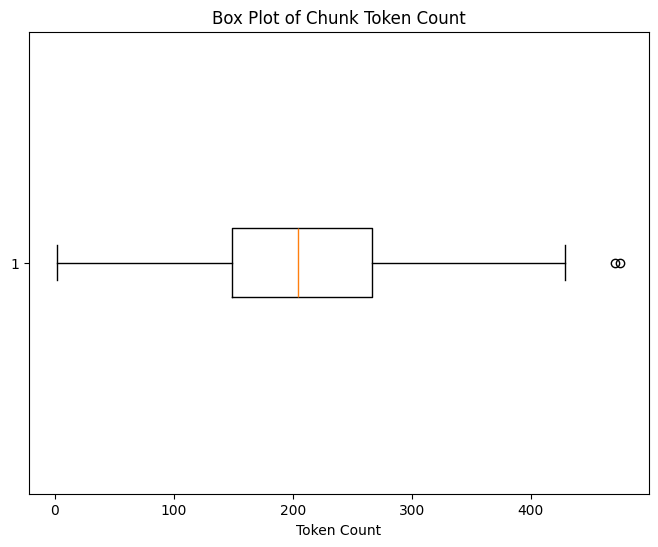

The percentile rank of token count = 384 is 98.23788546255506%


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Descriptive statistics
min_val = df["chunk_token_count"].min()
q1_val = df["chunk_token_count"].quantile(0.25)
median_val = df["chunk_token_count"].median()
q3_val = df["chunk_token_count"].quantile(0.75)
max_val = df["chunk_token_count"].max()

# Print the values
print(f"Min: {min_val}")
print(f"Q1: {q1_val}")
print(f"Median: {median_val}")
print(f"Q3: {q3_val}")
print(f"Max: {max_val}")

# Box plot
plt.figure(figsize=(8, 6))
# plt.boxplot(df["chunk_token_count"], vert=False)
plt.boxplot(df["chunk_token_count"], vert=False, whis=1.5)  # Default

plt.title('Box Plot of Chunk Token Count')
plt.xlabel('Token Count')
plt.show()

# Percentile rank for token count = 384
token_count = 384
percentile_rank = stats.percentileofscore(df["chunk_token_count"], token_count)

# Print percentile rank
print(f"The percentile rank of token count = {token_count} is {percentile_rank}%")


With 8 sentences as chunk limit, I got 93.56 percentile rank for 384 tokens. As, I don't want the embedding model to miss any token info, I will reduce it to 7.

With seven sentences, I got 98.23 chunks with token count <= 384 tokens, so, I am moving forward with it!

In [79]:
df[0:5]

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,1,STUDENT INFORMATION HANDBOOK 2024 Version II,44,6,11.00
1,2,Page 2 of 89 INDEX Chapter Title Page No. 1. ...,410,66,102.50
2,2,"Course Registration, Mapping of Research Super...",313,46,78.25
3,2,"Discipline, Code of Ethics, Conduct Rules and ...",218,31,54.50
4,3,Page 3 of 89 Chapter Title Page No. The Sexua...,775,118,193.75


In [87]:
#Show random chunks with under 5 tokens in length

min_token_length = 5
for row in df[df['chunk_token_count'] <= min_token_length].iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')
    

Chunk token count: 1.5 | Text: Direct
Chunk token count: 4.0 | Text: End of chapter 4
Chunk token count: 4.0 | Text: End of chapter 5
Chunk token count: 4.0 | Text: End of chapter 6
Chunk token count: 4.25 | Text: End of chapter 13
Chunk token count: 4.0 | Text: 2. Working hours


In [88]:
#Filter our DataFrame for rows with under 5 tokens
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_length]
print(type(pages_and_chunks_over_min_token_len))
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_length].to_dict(orient="records")#Gives us a list of dictionaries
print(type(pages_and_chunks_over_min_token_len))

<class 'pandas.core.frame.DataFrame'>
<class 'list'>


In [95]:
len(pages_and_chunks_over_min_token_len)

221

In [89]:
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 1,
  'sentence_chunk': 'STUDENT INFORMATION HANDBOOK 2024 Version II',
  'chunk_char_count': 44,
  'chunk_word_count': 6,
  'chunk_token_count': 11.0},
 {'page_number': 2,
  'sentence_chunk': 'Page 2 of 89 INDEX Chapter  Title Page No. 1. Course Programmes [MTech, MTech (Online), MDes, MMgt, MSc, MEngg, 1+1 Joint Masters] 5 2. PG – Research Programmes – MTech (Res) 12 3. PhD Programmes – Science, Engineering, and Interdisciplinary Research 17 4. Integrated PhD Programmes 25 5. External Registration Programmes – PhD and MTech (Res), Quality Improvement Programme (QIP) and Sponsored Programme 31 6.',
  'chunk_char_count': 410,
  'chunk_word_count': 66,
  'chunk_token_count': 102.5}]

In [90]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 26,
  'sentence_chunk': 'Page 26 of 89  4.2.4 The third semester and the fourth semester coursework will be chosen on the advice of the project supervisor. It is desirable but not mandatory that the supervisor consults the coordinator in this context. 4.2.5 In the third semester, the student may commence the project work leading to the PhD degree. 4.2.6 Exemption: 4.2.6.1 Within 15 days of registering for a core course, a student may apply to the coordinator of the Int. PhD programme seeking exemption from a core course if the student had credited the same course or a course with a similar syllabus in their prior education. This option is available to all students except for those in the Division of Chemical Sciences. If the Chair and coordinator approve, the student shall take a written examination, (prior to the last date for dropping the Course without mention).',
  'chunk_char_count': 852,
  'chunk_word_count': 145,
  'chunk_token_count': 213.0}]

In [91]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")

/data2/home/rajkamalr/miniconda3/envs/nlpAss1/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [94]:
%%time

embedding_model.to("cuda:3")

#Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 221/221 [00:18<00:00, 11.72it/s]

CPU times: user 15min 38s, sys: 2.56 s, total: 15min 41s
Wall time: 21.5 s


In [97]:
#Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "handbook_text_chunks_and_embeddings_df_0.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)


In [98]:
#Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,STUDENT INFORMATION HANDBOOK 2024 Version II,44,6,11.00,[ 6.80266879e-03 -4.28369194e-02 -1.99818071e-...
1,2,Page 2 of 89 INDEX Chapter Title Page No. 1. ...,410,66,102.50,[-1.77666713e-02 -1.03980936e-01 -3.92144583e-...
2,2,"Course Registration, Mapping of Research Super...",313,46,78.25,[ 1.49081470e-02 -4.33656387e-02 -2.63400562e-...
3,2,"Discipline, Code of Ethics, Conduct Rules and ...",218,31,54.50,[ 5.34446314e-02 5.67224547e-02 7.96027831e-...
4,3,Page 3 of 89 Chapter Title Page No. The Sexua...,775,118,193.75,[ 8.39489773e-02 -1.54819740e-02 -2.42535453e-...
